In [3]:
#!pip install tensorflow
#im using google colab so i needed to install this with a cell

In [4]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [5]:
import tensorflow as tf
# Uncomment the line below to restrict TensorFlow to a specific GPU memory usage
# gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # Set GPU memory options to limit TensorFlow's GPU usage

import tensorflow.keras as keras  # Import TensorFlow's Keras API
from keras import backend as K    # Import backend functions, such as session configurations, from Keras
import numpy as np                # Import NumPy for numerical operations
%matplotlib inline
import matplotlib.pyplot as plt   # Import Matplotlib's pyplot to plot graphs, %matplotlib inline ensures plots are shown inline in Jupyter notebooks

print(tf.__version__)             # Print the TensorFlow version
print(keras.__version__)          # Print the Keras version used within TensorFlow


2.18.0
3.8.0


In [6]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


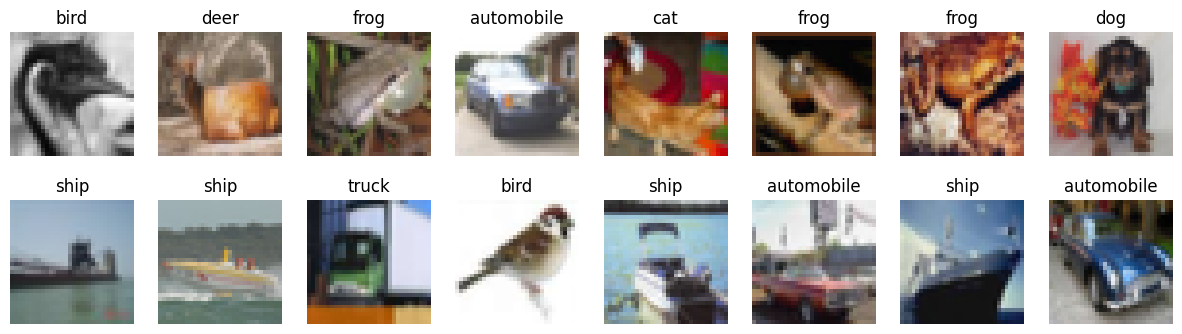

In [7]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [8]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [9]:
# import necessary building blocks
from keras.layers import LeakyReLU

In [10]:
from keras.models import Sequential # layer
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization

# Function to create a Keras model for image classification
def make_model(input_shape, num_classes):
    model = Sequential()  # Initialize a sequential model

    # First block of convolutional layers
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))  # Convolutional layer with 32 filters of size 3x3
    model.add(BatchNormalization())  # Normalize the activations of the previous layer at each batch
    model.add(Activation('relu'))    # ReLU activation function to introduce non-linearity
    model.add(Conv2D(32, (3, 3), padding='same'))  # Another convolutional layer with 32 filters of size 3x3
    model.add(BatchNormalization())  # Batch normalization layer
    model.add(Activation('relu'))    # ReLU activation function
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling operation with a 2x2 window to reduce spatial dimensions
    model.add(Dropout(0.25))         # Dropout layer to reduce overfitting by omitting some features during training

    # Second block of convolutional layers
    model.add(Conv2D(64, (3, 3), padding='same'))  # Convolutional layer with 64 filters of size 3x3
    model.add(BatchNormalization())  # Batch normalization layer
    model.add(Activation('relu'))    # ReLU activation function
    model.add(Conv2D(64, (3, 3), padding='same'))  # Another convolutional layer with 64 filters of size 3x3
    model.add(BatchNormalization())  # Batch normalization layer
    model.add(Activation('relu'))    # ReLU activation function
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling layer
    model.add(Dropout(0.25))         # Dropout layer to prevent overfitting

    # Third block of convolutional layers
    model.add(Conv2D(128, (3, 3), padding='same'))  # Convolutional layer with 128 filters of size 3x3
    model.add(BatchNormalization())  # Batch normalization layer
    model.add(Activation('relu'))    # ReLU activation function
    model.add(Conv2D(128, (3, 3), padding='same'))  # Another convolutional layer with 128 filters of size 3x3
    model.add(BatchNormalization())  # Batch normalization layer
    model.add(Activation('relu'))    # ReLU activation function
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling layer
    model.add(Dropout(0.25))         # Dropout layer to reduce overfitting

    # Flatten the network to transition to fully connected layers
    model.add(Flatten())             # Flatten the 3D output to 1D for the fully connected layers
    model.add(Dense(512))            # Fully connected layer with 512 units
    model.add(BatchNormalization())  # Batch normalization layer
    model.add(Activation('relu'))    # ReLU activation function
    model.add(Dropout(0.5))          # Dropout layer to prevent overfitting

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))  # Output layer with a softmax activation for multi-class classification

    return model  # Return the constructed model


In [11]:
import keras
from keras.callbacks import LearningRateScheduler
import numpy as np

INIT_LR = 1e-3  # reduced learning rate from original(was 3 or 4 e-3)
BATCH_SIZE = 16  # smaller batch size to introduce more noise, though takes quite some time to fiunish
EPOCHS = 30  # i chose 30 so it has a better accurucy

#fucntion for time based decaye , decay constant = 0.01.
# function to make the training process more accurate, more percise.
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + 0.01 * epoch)

K.clear_session()  # clear pprevious model to Clear memory
# Provide input_shape and num_classes to make_model
model = make_model(input_shape=x_train.shape[1:], num_classes=10)  # call model

model.compile( #compile model with Adam, its a better optinmiser
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),  # Switch to Adam for potentially better performance
    metrics=['accuracy']
)

# fit model with learning rate scheduler
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, # epochs
    validation_data=(x_val, y_val),
    shuffle=True,
    callbacks=[LearningRateScheduler(lr_time_based_decay)] #adjust the learning rate with the function we called earlier above
)

# save weights to file to avoid re-training
model.save_weights("myweights.weights.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.3702 - loss: 1.8512 - val_accuracy: 0.5952 - val_loss: 1.1425 - learning_rate: 0.0010
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.6047 - loss: 1.1225 - val_accuracy: 0.6658 - val_loss: 0.9310 - learning_rate: 9.9010e-04
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.6791 - loss: 0.9264 - val_accuracy: 0.6855 - val_loss: 0.9131 - learning_rate: 9.7069e-04
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7200 - loss: 0.8124 - val_accuracy: 0.7542 - val_loss: 0.6977 - learning_rate: 9.4241e-04
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.7485 - loss: 0.7280 - val_accuracy: 0.7788 - val_loss: 0.6332 - learning_rate: 9.0617e-04
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7675 - loss: 0.6684 - val_accuracy: 0.8096 - val_loss: 0.5560 - learning_rate: 8.6302e-04
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/

In [12]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


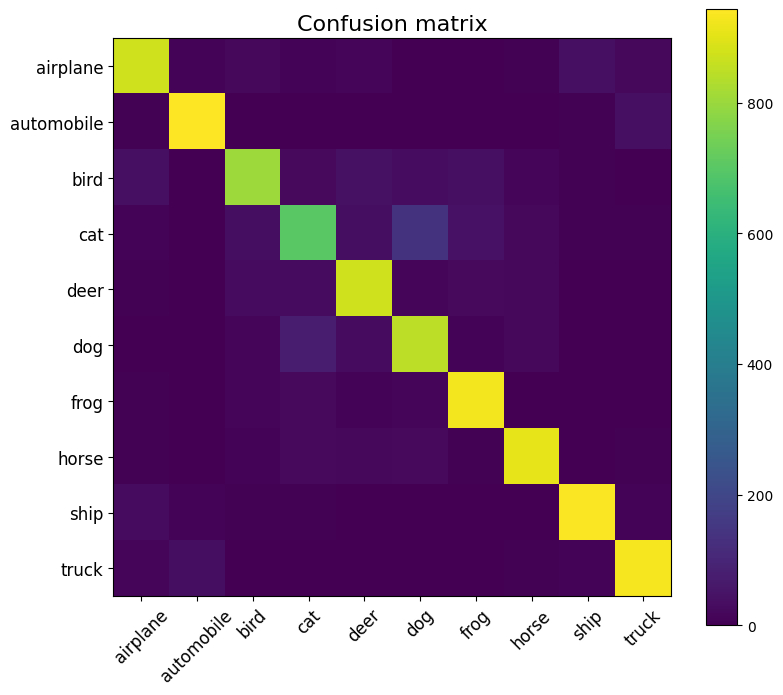

Test accuracy: 0.8749


In [13]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(9, 8))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

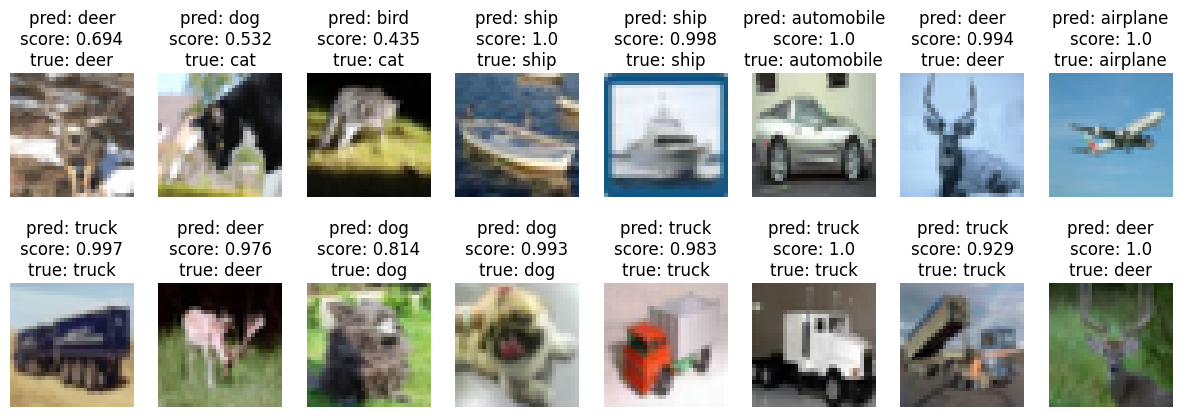

In [14]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


